In [1]:
import torch
import torchvision
import random
import matplotlib.pyplot as plt
from torchvision import datasets
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
imagenet_data = torchvision.datasets.MNIST('files/', train=True, download=True,)

imagenet_data_test = torchvision.datasets.MNIST('files/', train=False, download=True,)

In [ ]:
class custom_dataset(Dataset):
  def __init__(self,data,label,batch_size):
    self.index=0
    self.total=data.shape[0]
    self.batch=batch_size
    # normalising to 0-1
    # training size
    self.data=data.to(torch.float)/255
    self.label=label
    # creating image for point
    self.point=torch.zeros((28,28),dtype=torch.float)
    self.point[20:23,12:15]=1

  def __getitem__(self, idx):
    # position of point in sequence
    dot=np.random.randint(1,6)
    #length of concatenation should be same in same batch
    y=random.Random(int(idx//self.batch)).randint(4,8)
    # creating empty image
    a=torch.zeros((int(28*2),28*y),dtype=torch.float)
    target=[[10]]
    
    # print(idx,y,self.index)
    for x in range(y):
      # random value of position to put image on y axis
      yy=np.random.randint(0,28)
      # augmenting the width
      g=np.random.randint(1,5)
      if x!=dot:
        a[yy:yy+28,x*28+g:(28*x)+28-g]=self.data[self.index][:,g:-g]
        target.append([self.label[self.index]])
      else:
        # cncatenating the point
        a[yy:yy+28,x*28+g:(28*x)+28-g]=self.point[:,g:-g]
        target.append([12])
      self.index=(self.index+1)%self.total #**
    target.append([11])
    return a.rot90(3).unsqueeze(0),torch.tensor(target[:-1]),torch.tensor(target[1:])
  def __len__(self):
    # idx used is only for generting lenth of concatenation 
    # because of random sequence length, self.index is used to reset after one epoch
    return self.total


In [ ]:

class encoder_decoder(nn.Module):
  def __init__(self,output):
    super().__init__()
    # total tokens 
    self.output=output
    self.maxpool1=torch.nn.MaxPool2d(2)
    self.maxpool2=torch.nn.MaxPool2d(2)
    self.cnn1=torch.nn.Conv2d(1,8,3,)
    self.cnn2=torch.nn.Conv2d(8,8,3)
    # final conv layer of 4 channels
    self.cnn3=torch.nn.Conv2d(8,4,3,) 
    # 2 layer gru with 32 units
    self.encgru=nn.GRU(40,32,2,batch_first=True,dropout=0.1)
    # for inputing one hot encoded digits
    self.emb=nn.Embedding(self.output,8)
    # 2 layer gru with 32 units
    self.decgru=nn.GRU(8,32,2,batch_first=True,dropout=0.1)
    # timeshared linear layer
    self.Linear=nn.Linear(32,self.output,bias=True,) 
  def forward(self,x,val):
    x=self.cnn1(x)
    x=nn.functional.relu(x)
    x=self.maxpool1(x)
    x=self.cnn2(x)
    x=nn.functional.relu(x)
    x=self.maxpool2(x)
    x=self.cnn3(x)
    x=nn.functional.relu(x)
    batch,channel,time,emb=x.shape
    # concatenating along the y axis
    x=x.permute(0,2,1,3).reshape(batch,time,emb*channel)
    # only hidden state is passed to decoder
    _,hidden=self.encgru(x)
    batch,time,embe=val.shape
    x=self.emb(val)
    x=nn.functional.relu(x)
    x=x.squeeze(2)
    x,_= self.decgru(x,hidden)
    x=nn.functional.relu(x)
    x=self.Linear(x.reshape(-1,32))
    return x
  def predict(self,x):
    t=[]
    x=self.cnn1(x)
    x=nn.functional.relu(x)
    x=self.maxpool1(x)
    x=self.cnn2(x)
    x=nn.functional.relu(x)
    x=self.maxpool2(x)
    x=self.cnn3(x)
    x=nn.functional.relu(x)
    batch,channel,time,emb=x.shape
    x=x.permute(0,2,1,3).reshape(batch,time,emb*channel)
    _,hidden=self.encgru(x)
    # <start> token index
    index=10
    pred=[index]
    # maximum length is less than 12
    for _ in range(12):
      x=self.emb(torch.tensor([[[index]]]))
      x=nn.functional.relu(x)
      x=x.squeeze(2)
      x,hidden= self.decgru(x,hidden)
      x=nn.functional.relu(x)
      x=self.Linear(x.reshape(-1,32))
      index=torch.argmax(x,-1)[0]
      pred.append(index.item())
      # if <end> token then break loop
      if index ==11:
        break
    return pred
# total 13 tokens are used, includes 10 digits + <start> + <end> + "."
model = encoder_decoder(13)

In [ ]:
model = encoder_decoder(13)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
dataload=custom_dataset(imagenet_data.data,imagenet_data.targets,batch_size=8)
iterate=DataLoader(dataload,batch_size=8)

dataload_test=custom_dataset(imagenet_data_test.data,imagenet_data_test.targets,batch_size=1)
iterate_test=DataLoader(dataload_test,batch_size=1)


In [ ]:
i=0
model.train()
best=0
model.to(device)
for ___ in range(40):
  for x in iterate:
    i+=1
    out=model(x[0].to(device),x[1].to(device))
    optimizer.zero_grad()
    LOSS=loss(out,x[2].view(-1).to(device))
    LOSS.backward()
    optimizer.step()
    
    if i%700==0:
        print("test_batch_loss :",LOSS.item())
        with torch.no_grad():
            losses=[]
            c=0
            for x in iterate_test:
                model.eval()
                LOSS=model(x[0].to(device),x[1].to(device))
                xx=torch.argmax(LOSS,-1).cpu()
                c+=xx.shape[-1]
                losses.append(torch.sum(xx==x[2].view(1,-1)))
            acc=np.sum(losses)/c
            print("validation acc :",np.sum(losses)/c)
            if acc>best:
                torch.save(model,"best__ocr.pt")
                best=acc
                print("best : ",acc)
            model.train() 
            print()
print("best validation accuracy :",best)


test_batch_loss : 2.2088332176208496
validation acc : 0.260311195011727
best :  0.260311195011727

test_batch_loss : 2.0686986446380615
validation acc : 0.316543675991076
best :  0.316543675991076

test_batch_loss : 1.993940830230713
validation acc : 0.32094845832618274
best :  0.32094845832618274

test_batch_loss : 1.7510820627212524
validation acc : 0.34066987014472855
best :  0.34066987014472855

test_batch_loss : 1.5346921682357788
validation acc : 0.3470625250271724
best :  0.3470625250271724

test_batch_loss : 1.8043229579925537
validation acc : 0.35671586293690294
best :  0.35671586293690294

test_batch_loss : 1.7535628080368042
validation acc : 0.3552428350780848

test_batch_loss : 1.6780078411102295
validation acc : 0.3693152565642698
best :  0.3693152565642698

test_batch_loss : 1.7991862297058105
validation acc : 0.36854298953149134

test_batch_loss : 1.6320440769195557
validation acc : 0.3789971969566958
best :  0.3789971969566958

test_batch_loss : 1.6159335374832153
valid

test_batch_loss : 0.798782229423523
validation acc : 0.686416680967908
best :  0.686416680967908

test_batch_loss : 0.6412976980209351
validation acc : 0.694225158743779
best :  0.694225158743779

test_batch_loss : 1.0377894639968872
validation acc : 0.6866025971054287

test_batch_loss : 0.8288699984550476
validation acc : 0.687160345517991

test_batch_loss : 0.7199370861053467
validation acc : 0.6969280933585035
best :  0.6969280933585035

test_batch_loss : 0.9846825003623962
validation acc : 0.6979005777701505
best :  0.6979005777701505

test_batch_loss : 1.1473331451416016
validation acc : 0.7068960585778845
best :  0.7068960585778845

test_batch_loss : 0.6337634921073914
validation acc : 0.7134317258738059
best :  0.7134317258738059

test_batch_loss : 0.851539134979248
validation acc : 0.7222412905440192
best :  0.7222412905440192

test_batch_loss : 0.8222437500953674
validation acc : 0.7229277501287111
best :  0.7229277501287111

test_batch_loss : 0.6961736083030701
validation acc

test_batch_loss : 0.2461581975221634
validation acc : 0.9379183113094216
best :  0.9379183113094216

test_batch_loss : 0.2503742277622223
validation acc : 0.9332561066300555

test_batch_loss : 0.5101195573806763
validation acc : 0.9274927063669126

test_batch_loss : 0.43280866742134094
validation acc : 0.9374177678622504

test_batch_loss : 0.24068661034107208
validation acc : 0.9331416966992735

test_batch_loss : 0.29620087146759033
validation acc : 0.9371460442766432

test_batch_loss : 0.34507811069488525
validation acc : 0.936931525656427

test_batch_loss : 0.10373436659574509
validation acc : 0.9389193982037641
best :  0.9389193982037641

test_batch_loss : 0.15409857034683228
validation acc : 0.9257193524397918

test_batch_loss : 0.28626036643981934
validation acc : 0.9333419140781419

test_batch_loss : 0.41664576530456543
validation acc : 0.9407928608203192
best :  0.9407928608203192

test_batch_loss : 0.31171146035194397
validation acc : 0.9374034666209027

test_batch_loss : 0.362

validation acc : 0.960857502431211

test_batch_loss : 0.32733047008514404
validation acc : 0.9592986671243063

test_batch_loss : 0.03566170111298561
validation acc : 0.9585264000915279

test_batch_loss : 0.27675068378448486
validation acc : 0.9537640867227275

test_batch_loss : 0.01245868019759655
validation acc : 0.9632315084949373
best :  0.9632315084949373

test_batch_loss : 0.3236742913722992
validation acc : 0.9561952977518449

test_batch_loss : 0.41299158334732056
validation acc : 0.9619586980149877

test_batch_loss : 0.14360633492469788
validation acc : 0.9586122075396144

test_batch_loss : 0.22657108306884766
validation acc : 0.9605428751215606

test_batch_loss : 0.2679142355918884
validation acc : 0.9587266174703964

test_batch_loss : 0.12442052364349365
validation acc : 0.9588410274011784

test_batch_loss : 0.37999090552330017
validation acc : 0.9626880613237229

test_batch_loss : 0.059489212930202484
validation acc : 0.9598278130541731

test_batch_loss : 0.20362074673175812


validation acc : 0.9689949087580803
best :  0.9689949087580803

test_batch_loss : 0.3185810446739197
validation acc : 0.9671643498655683

test_batch_loss : 0.14413413405418396
validation acc : 0.9657199244894457

test_batch_loss : 0.2821660041809082
validation acc : 0.9673216635203936

test_batch_loss : 0.20529332756996155
validation acc : 0.9650620673874493

test_batch_loss : 0.15429003536701202
validation acc : 0.9672930610376981

test_batch_loss : 0.05437014624476433
validation acc : 0.943252674332132

test_batch_loss : 0.02740328200161457
validation acc : 0.9684943653109089

test_batch_loss : 0.37831225991249084
validation acc : 0.9694239459985127
best :  0.9694239459985127

test_batch_loss : 0.17307625710964203
validation acc : 0.9691093186888622

test_batch_loss : 0.456216961145401
validation acc : 0.9681940392426063

test_batch_loss : 0.14464247226715088
validation acc : 0.9604999713975173

test_batch_loss : 0.05446276068687439
validation acc : 0.966277672902008

test_batch_loss

In [ ]:
torch.save(model,"best__ocr.pt")


In [ ]:
model=torch.load("best__ocr.pt", map_location=torch.device('cpu'))



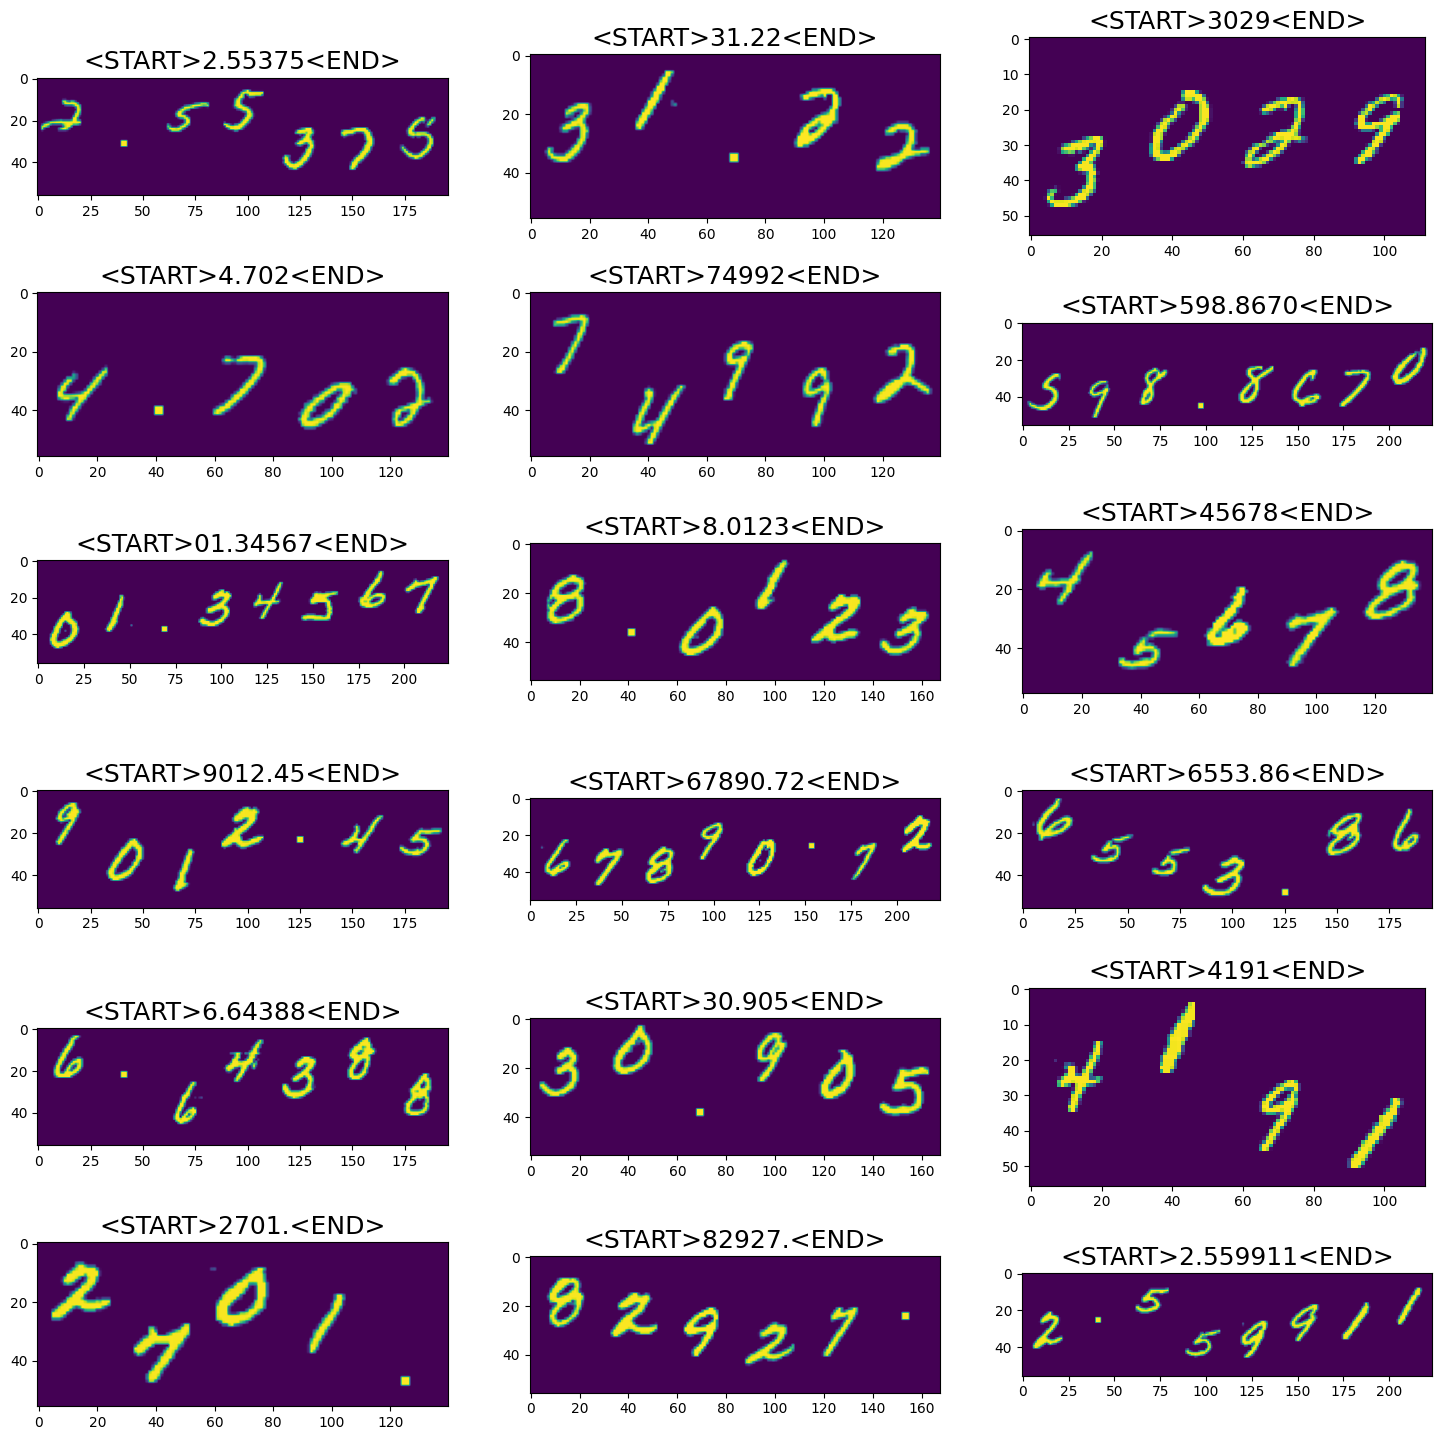

In [ ]:
map_index={10:"<START>",11:"<END>",12:"."}
_, axs = plt.subplots(6, 3, figsize=(18, 18))
axs = axs.flatten()
i=0
for id,(x,ax) in enumerate(zip(iterate_test,axs)):
  if id==18:
    break
  ax.imshow(x[0][0,0].numpy().transpose()[::-1])
  out=model.predict(x[0])
  ax.set_title("".join(list(map(lambda i : str(map_index[i] if i in map_index else str(i)),out))),color="black",fontsize=18)
plt.savefig("abc.jpeg")

device(type='cuda')